In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_tradehistory, get_mytrades, get_pnl, get_midprice_mm, get_orderbook

Process price data

In [27]:
price = pd.read_csv("data/current.csv", delimiter=";")
resin = price.loc[price["product"]=="RAINFOREST_RESIN"]
kelp = price.loc[price["product"]=="KELP"]

In [22]:
mp = get_midprice_mm(kelp)
kelp["mid_price"] = mp

/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_2554/3810034068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp["mid_price"] = mp


Process log file

In [28]:
infile = r"data/current.log"

In [ ]:
## get price data

# fp = open(infile)
# start = False
# start_signal = "Activities log"
# end_signal = "Trade History"
# outfile = "data/test.txt"

# with open(outfile, "w") as f:

#     for line in fp:

#         if not start:
#             if start_signal in line:
#                 start = True

#         elif start:
#             if end_signal in line:
#                 break
            
#             f.write(line)
             
# f.close()
# fp.close()


In [53]:
# log = pd.read_csv(outfile, delimiter=";")

In [29]:
# the entire trade history (not just own trades)
hist = get_tradehistory(infile)
resin_hist = get_mytrades(hist)
# resin_hist = resin_hist.merge(kelp[["timestamp", "mid_price"]], on="timestamp", how="left")
kelp_hist = get_mytrades(hist, "KELP")
kelp_hist = kelp_hist.merge(kelp[["timestamp", "mid_price"]], on="timestamp", how="left")

kelp_hist_copy = kelp_hist.copy()
arr = kelp_hist_copy.loc[kelp_hist_copy["seller"]=="SUBMISSION"]["quantity"].array * -1
kelp_hist_copy.loc[kelp_hist_copy["seller"]=="SUBMISSION", "quantity"] = arr
kelp_hist["position"] = kelp_hist_copy["quantity"].cumsum()

In [17]:
# get order book
orderbook = get_orderbook("data/orderbook.log")

Analyse order book; compare with price data

In [164]:
for time in orderbook.keys():
    df = kelp.loc[kelp["timestamp"]==time]
    buyprices = df[["bid_price_1", "bid_price_2", "bid_price_3"]].values.flatten()
    buyvolumes = df[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].values.flatten()
    sellprices = df[["ask_price_1", "ask_price_2", "ask_price_3"]].values.flatten()
    sellvolumes = df[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].values.flatten()
    buys = {p: int(v) for p, v in zip(buyprices, buyvolumes) if pd.notna(p) and pd.notna(v)}
    sells = {p: -int(v) for p, v in zip(sellprices, sellvolumes) if pd.notna(p) and pd.notna(v)}

    if buys != orderbook[time]["buy"]:
        print("different buy; ", time)
    if sells != orderbook[time]["sell"]:
        print("different sell; ", time)
    

different sell;  57900
different sell;  82600
different sell;  130200


In [18]:
# update true fairprice based on live orderbook
for time in [57900, 82600, 130200]:
    selldict = orderbook[time]["sell"]
    buydict = orderbook[time]["buy"]
    trueask = min(selldict, key=selldict.get)
    truebid = max(buydict, key=buydict.get)
    kelp.loc[kelp["timestamp"] == time, "mid_price"] = (trueask+truebid)/2

#### Research algorithms

#### Resin

In [171]:
resin_hist = get_mytrades(hist)

<Axes: >

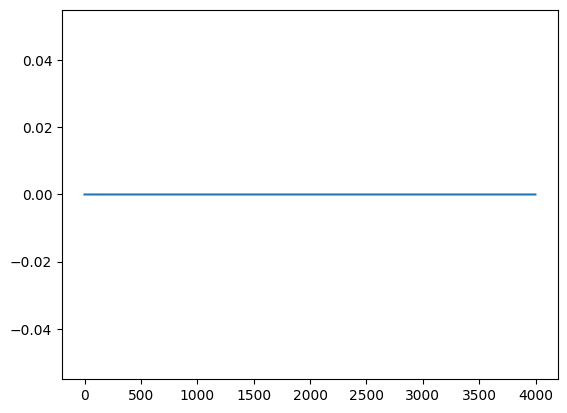

In [ ]:
resin["profit_and_loss"].plot()

#### Kelp

Buy and sell signals with Bollinger bands

In [253]:
def ma(arr, window, mult1, mult2):
    start = window
    sma, lower, upper = [], [], []

    while start <= len(arr):
        moving = arr[start-window:start]
        sma.append(np.mean(moving))
        upper.append(np.mean(moving) + mult1 * np.std(moving))
        lower.append(np.mean(moving) - mult2 * np.std(moving))
        start += 1
    
    return sma, upper, lower

In [10]:
mp = kelp["mid_price"].array         # "true" midprice of the game
ts = kelp["timestamp"].array
ask = kelp["ask_price_1"].array
bid = kelp["bid_price_1"].array

In [120]:
buyst = np.where(ask <= mp)[0]
sellst = np.where(bid >= mp)[0]

In [314]:
w = 20
sma, upper, lower = ma(mp, w, 1.75, 1.75)

low_touch, up_touch = [], []
count = w - 1
status = ""

hit_low, hit_up = 0, 0

for mean, low, up, mid in zip(sma, lower, upper, mp[w-1:]):
    if mid <= low:
        hit_low += 1
        hit_up = 0
    elif mid >= up:
        hit_up += 1
        hit_low = 0
    else:
        hit_low, hit_up = 0, 0

    if hit_low >= 1 and status != "buy" and ask[count] <= mp[count]:
        low_touch.append(count)
        status = "buy"
    elif hit_up >= 1 and status != "sell" and bid[count] >= mp[count]:
        up_touch.append(count)
        status = "sell"

    count += 1

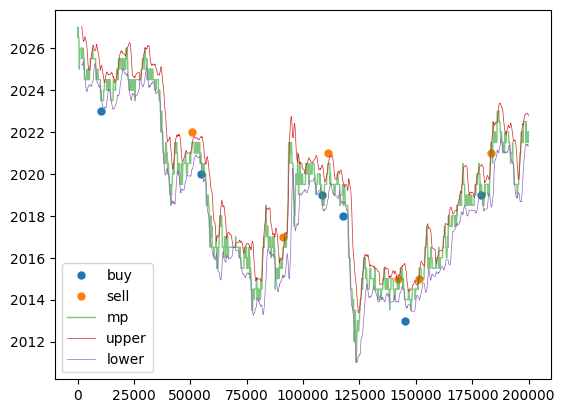

In [315]:
# plt.plot(ts[buyst], ask[buyst], lw=0, ms=10, marker='.', label="buy")
# plt.plot(ts[sellst], bid[sellst], lw=0, ms=10, marker='.', label="sell")

plt.plot(ts[low_touch], ask[low_touch], label="buy", lw=0, ms=10, marker='.')
plt.plot(ts[up_touch], bid[up_touch], label="sell", lw=0, ms=10, marker='.')

plt.plot(ts, mp, lw=1, alpha=0.6, label="mp")
plt.plot(ts[w-1:], upper, label="upper", lw=0.5)
plt.plot(ts[w-1:], lower, label="lower", lw=0.5)

plt.legend()
plt.show()

Live performance

In [30]:
kelp_buy = kelp_hist.loc[kelp_hist["buyer"]=="SUBMISSION"]
kelp_sell = kelp_hist.loc[kelp_hist["seller"]=="SUBMISSION"]
buy_time = list(kelp_buy["timestamp"])
buy_price = list(kelp_buy["price"])
sell_time = list(kelp_sell["timestamp"])
sell_price = list(kelp_sell["price"])

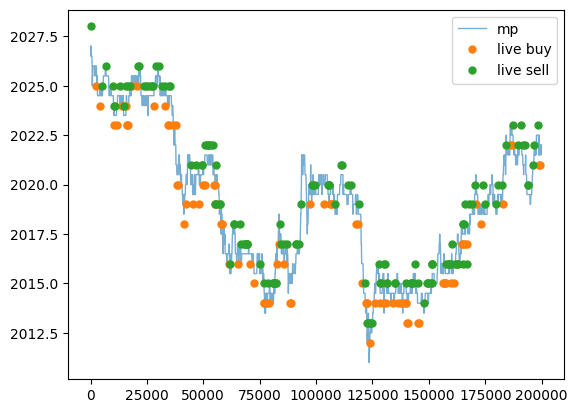

In [31]:
plt.plot(ts, mp, lw=1, alpha=0.6, label="mp")
plt.plot(buy_time, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.plot(sell_time, sell_price, lw=0, ms=10, marker='.', label="live sell")

plt.legend()
plt.show()

Eric liu's algo

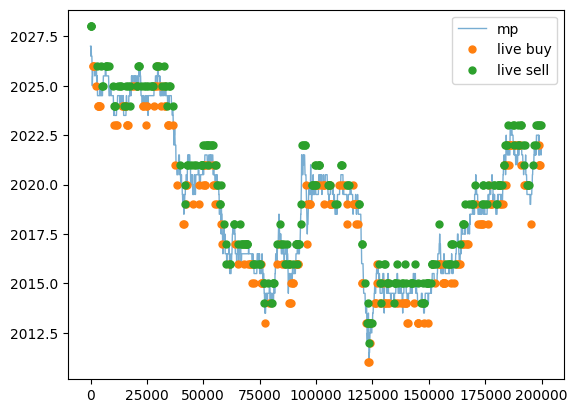

In [26]:
plt.plot(ts, mp, lw=1, alpha=0.6, label="mp")
plt.plot(buy_time, buy_price, lw=0, ms=10, marker='.', label="live buy")
plt.plot(sell_time, sell_price, lw=0, ms=10, marker='.', label="live sell")

plt.legend()
plt.show()